<h1><b> CLUSTERING-CITRA-SATELIT </b></h1>

---

📝 **Notebook: 4_anomaly_detection.ipynb**

Notebook ini digunakan untuk melakukan **deteksi anomali** pada data hasil ekstraksi fitur citra satelit sekolah.  
Tujuan utamanya adalah **mengidentifikasi citra sekolah yang memiliki karakteristik berbeda secara signifikan** dibandingkan mayoritas data — misalnya, gambar yang rusak, salah deteksi, atau memiliki pola unik secara visual.  

Hasil analisis anomali ini penting untuk memastikan bahwa data yang akan digunakan dalam tahap **clustering** benar-benar representatif dan bersih dari noise.  

---

📂 **Sumber Data**

Data yang digunakan berasal dari hasil ekstraksi fitur pada tahap sebelumnya:  

- **`../hasil/features/features/*.npy`** → file berisi vektor fitur hasil ekstraksi (HOG, LBP, Warna, VGG16, ResNet, MobileNet).  
- **`../data/data_preprocessing.csv`** → metadata sekolah hasil preprocessing (berisi informasi lokasi, akreditasi, dan path gambar).  
- **`../data/gambar/...`** → data citra satelit sekolah yang digunakan untuk validasi hasil deteksi anomali.  

Dataset ini memuat total **14.076 sekolah** dengan fitur visual berdimensi tinggi yang telah siap dianalisis.

---

⚙️ **Tahapan Anomaly Detection**

Beberapa langkah utama dalam notebook ini meliputi:  

1. **LIBRARY**  
   Mengimpor seluruh library yang dibutuhkan untuk proses deteksi anomali.  

2. **CONFIGURATION**  
   Menentukan konfigurasi awal seperti direktori input/output, parameter, dan pengaturan acak (`random_state`) agar hasil analisis dapat direproduksi dengan konsisten.  

3. **LOAD METADATA & FITUR**  
   Memuat data fitur hasil ekstraksi (`.npy` atau `.csv`) serta metadata sekolah (`data_preprocessing.csv`).  
   Pada tahap ini juga dilakukan sinkronisasi indeks antar-data, normalisasi fitur (jika diperlukan), dan pengecekan kesesuaian jumlah sampel.  

4. **DETEKSI ANOMALI**  
   - Menggunakan metode berbasis rata-rata dari PCA.
   - Menyimpan visualisasi hasil dalam folder output.
   
5. **PENYIMPANAN HASIL**  
   - Menyimpan hasil deteksi `anomaly_label`, `score` ke file `data_deteksi_anomali.csv`.
 

---

📊 **Hasil yang Diperoleh**

Notebook ini menghasilkan:  

- Label anomali untuk setiap citra sekolah (`0 = normal`, `1 = anomali`)  
- File hasil deteksi anomali ke file `../data/data_deteksi_anomali.csv`  
- Visualisasi distribusi fitur dengan penandaan titik-titik anomali  
- Daftar dan contoh citra yang dideteksi sebagai anomali  
- Insight awal tentang kualitas dan keunikan data citra  

Semua hasil akhir akan disimpan di folder:  
📂 **`../hasil/anomaly_detection/`**

---

✨ **Tujuan Akhir**

Menjamin kualitas dataset dengan **menghapus atau meninjau ulang data anomali** sebelum proses **clustering** dilakukan.


---
# **LIBRARY**
---

In [1]:
# ============================
# Standard Library
# ============================
import os
from tqdm import tqdm

# ============================
# Data Manipulation
# ============================
import numpy as np
import pandas as pd

# ============================
# Image Processing
# ============================
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from skimage.feature import hog, local_binary_pattern

# ============================
# Visualization
# ============================
import matplotlib.pyplot as plt
import plotly.express as px

# ============================
# Feature Analysis & Clustering
# ============================
from sklearn.decomposition import PCA

---
# **CONFIGURATION**
---

⚙️ **Konfigurasi Path dan Output**

Pada tahap ini dilakukan pengaturan direktori kerja untuk memastikan seluruh data dapat diakses dan hasil analisis tersimpan dengan benar.  
Konfigurasi ini bersifat penting karena notebook hanya akan berjalan jika path data sesuai dengan struktur folder proyek.

📂 **Penjelasan Variabel:**

- `METADATA_DIR` → Path menuju file metadata sekolah hasil preprocessing (`data_preprocessing.csv`).  
- `IMAGE_DIR` → Direktori yang berisi kumpulan citra satelit sekolah yang digunakan untuk validasi hasil deteksi anomali.  
- `FEATURE_DIR` → Lokasi penyimpanan data fitur hasil ekstraksi (dari notebook `3_feature_extractions.ipynb`).  
- `OUTPUT_DIR` → Folder output untuk menyimpan hasil deteksi anomali, grafik, dan file pendukung lainnya.  

In [2]:
# ============================
# Path Configuration            # Data harus ada sebelum dijalankan
# ============================
METADATA_DIR = "../data/data_preprocessing.csv" 
IMAGE_DIR = "../data/gambar" 
FEATURE_DIR = "../hasil/features/features"                       

# ============================
# Output Configuration          # Akan dibuat otomatis
# ============================
OUTPUT_DIR = "../hasil/anomaly_detection"
os.makedirs(OUTPUT_DIR, exist_ok=True)

---
# **LOAD METADATA & FITUR**
---

Tahap ini bertujuan untuk **memuat metadata sekolah** dan **mengimpor data fitur hasil ekstraksi citra** agar siap digunakan dalam proses deteksi anomali.

📂 **Penjelasan Langkah:**

1. **Memuat Metadata Sekolah**  
   - File: `data_preprocessing.csv`  
   - Berisi informasi utama seperti:
     - `nomor` → identitas unik sekolah  
     - `nama_sekolah`, `provinsi`, `kota`  
     - `akreditasi` (A, B, C)  
     - Path citra satelit hasil scraping dan preprocessing  
   - Informasi ini digunakan untuk menghubungkan setiap vektor fitur dengan sekolah yang sesuai.

2. **Memuat Fitur Citra (Feature Embedding)**  
   - Data fitur diambil dari hasil ekstraksi sebelumnya (`../hasil/features/`) dan disimpan dalam format `.npy`.  
   - Fitur yang dimuat:  
     - **HOG** 
     - **LBP**
   - > Fitur diatas dipilih berdasarkan analisis sebelumnya. **HOG** dan **LBP** dapat memisahkan data anomali dari data yang lain.
   - Seluruh fitur disatukan dalam list `features_list` untuk memudahkan proses looping dan analisis.

3. **Menyiapkan Label dan Indeks Data**  
   - `y` berisi label akreditasi sekolah.  
   - `index` berisi nomor unik sekolah yang digunakan untuk identifikasi selama visualisasi.


In [3]:
# ============================
# Load Metadata
# ============================
df_ori = pd.read_csv(METADATA_DIR)

print("Jumlah baris   :", len(df_ori))
print("Jumlah kolom   :", df_ori.shape[1])

# Tampilkan 5 baris pertama
df_ori.head()

Jumlah baris   : 14076
Jumlah kolom   : 13


nomor kode_sekolah                  nama_sekolah  \
0      1     10100139  SMA NEGERI 1 LEMBAH SEULAWAH   
1      2     10100170       SMA NEGERI MODAL BANGSA   
2      3     10100176            SMAS MALEM PUTRA 1   
3      4     10100177          SMA NEGERI 1 LEUPUNG   
4      5     10100179        SMA NEGERI 1 PULO ACEH   

                                              alamat  kabupaten_kota provinsi  \
0  JL. BANDA ACEH-MEDAN KM.57,5 Lamtamot Kec. Lem...  Kab Aceh Besar     Aceh   
1  JL. BANDARA SIM KM. 12,5 Cot Geundreut Kec. Bl...  Kab Aceh Besar     Aceh   
2  JL.SYEH ABDULLAH KAN-AN Leugeu Kec. Darul Imar...  Kab Aceh Besar     Aceh   
3  JL. BANDA ACEH CALANG KM-18 DAYAH MAMPLAM Kec....  Kab Aceh Besar     Aceh   
4  JL. RAJA KANDANG Alue Riyeung Kec. Pulo Aceh K...  Kab Aceh Besar     Aceh   

  akreditasi       long       lat  \
0          A  95.682881  5.370129   
1          A  95.395695  5.508437   
2          C  95.330857  5.493038   
3          B  95.241723  5.435694   
4          B  95.144949  5.615454   

                                      dir_gambar_ori  \
0  ../data/gambar/gambar_ori/ACEH/KAB ACEH BESAR/...   
1  ../data/gambar/gambar_ori/ACEH/KAB ACEH BESAR/...   
2  ../data/gambar/gambar_ori/ACEH/KAB ACEH BESAR/...   
3  ../data/gambar/gambar_ori/ACEH/KAB ACEH BESAR/...   
4  ../data/gambar/gambar_ori/ACEH/KAB ACEH BESAR/...   

                                    dir_gambar_titik  \
0  ../data/gambar/gambar_titik/ACEH/KAB ACEH BESA...   
1  ../data/gambar/gambar_titik/ACEH/KAB ACEH BESA...   
2  ../data/gambar/gambar_titik/ACEH/KAB ACEH BESA...   
3  ../data/gambar/gambar_titik/ACEH/KAB ACEH BESA...   
4  ../data/gambar/gambar_titik/ACEH/KAB ACEH BESA...   

                           dir_gambar_kotak_dan_yolo keterangan  
0  ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses  
1  ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses  
2  ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses  
3  ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses  
4  ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses

In [4]:
import os

hog_features = np.load(os.path.join(FEATURE_DIR, "hog_features.npy"))
lbp_features = np.load(os.path.join(FEATURE_DIR, "lbp_features.npy"))

# List fitur dan nama untuk loop
features_list = [hog_features, lbp_features]
feature_names = ["HOG", "LBP"]

y = df_ori['akreditasi'].values     # label akreditasi
index = df_ori['nomor'].values      # informasi nomor

---
# **DETEKSI ANOMALI**
---

---

🚨 **Deteksi Anomali pada Data Fitur**

Tahap ini bertujuan untuk mengidentifikasi **sekolah-sekolah dengan citra satelit yang memiliki karakteristik tidak umum (anomali)** berdasarkan distribusi fitur hasil ekstraksi citra.

Seperti yang telah dianalisis sebelumnya, metode **handcrafted features** seperti **HOG (Histogram of Oriented Gradients)** dan **LBP (Local Binary Pattern)** memberikan hasil yang sangat baik dalam membedakan pola struktur dan tekstur bangunan sekolah.  
Oleh karena itu, kedua jenis fitur ini digunakan dalam proses deteksi anomali ini.

---

🔍 **Metode Deteksi**

Pendekatan yang digunakan berbasis **analisis distribusi spasial fitur** menggunakan **PCA (Principal Component Analysis)** untuk reduksi dimensi dan perhitungan jarak dari *centroid* data.

1. **Reduksi Dimensi (PCA 3D)**  
   - Data fitur (misalnya HOG atau LBP) direduksi ke 3 dimensi utama menggunakan PCA.  
   - Tujuannya agar struktur distribusi data dapat divisualisasikan secara intuitif dalam ruang 3D.  

2. **Perhitungan Jarak Euclidean**  
   - Setiap titik fitur dihitung jaraknya terhadap *centroid* distribusi (rata-rata posisi semua titik).  
   - Titik dengan jarak jauh dari centroid dianggap memiliki perilaku yang berbeda dari mayoritas.  

3. **Z-Score Normalization**  
   - Nilai jarak dinormalisasi menggunakan z-score untuk mengukur seberapa jauh titik tersebut dari pusat distribusi relatif terhadap sebaran keseluruhan.  
   - Titik dengan nilai `z-score > threshold` (misal 3) dikategorikan sebagai **Anomali**, sisanya **Umum**.  

4. **Visualisasi Interaktif (Plotly 3D)**  
   - Hasil deteksi divisualisasikan menggunakan scatter plot interaktif berbasis Plotly.  
   - Titik-titik anomali ditampilkan dengan warna berbeda untuk memudahkan identifikasi pola.  
   - Saat kursor diarahkan ke titik tertentu, akan muncul informasi sekolah (melalui hover).  

5. **Menampilkan Citra Sekolah Anomali (Matplotlib Grid)**  
   - Citra satelit dari sekolah yang terdeteksi anomali ditampilkan dalam bentuk grid menggunakan Matplotlib.  
   - Hal ini membantu melakukan **validasi visual**, apakah citra anomali benar-benar tampak tidak wajar (misalnya terlalu gelap, blur, bukan bangunan sekolah, atau tertutup awan).

---

Dua fungsi berikut digunakan untuk membantu proses analisis anomali secara visual dan dokumentasi hasil:

1. **`plot_pca_3d()`**
   - Melakukan reduksi dimensi menggunakan **PCA 3D**.
   - Menampilkan hasil dalam bentuk **plot interaktif 3D** dengan warna berdasarkan status (`Umum` vs `Anomali`).
   - Menyimpan hasil:
     - Plot interaktif → `../hasil/anomaly_detection/{nama_fitur}_pca_anomaly.html`
     - Daftar nomor sekolah anomali → `../hasil/anomaly_detection/{nama_fitur}_anomali_list.csv`

2. **`plot_anomaly_images()`**
   - Menampilkan kumpulan **citra sekolah yang terdeteksi anomali** dalam bentuk grid.
   - Menyimpan hasil visualisasi ke file:
     - `../hasil/anomaly_detection/{nama_fitur}_anomali_images_grid.png`

Hasil ini digunakan untuk **memvalidasi deteksi anomali** serta **menyimpan dokumentasi hasil visualisasi**.

---

🎯 **Tujuan Akhir**

Tujuan utama dari deteksi anomali ini adalah untuk:
- **Membersihkan dataset** dari citra yang tidak representatif atau salah deteksi.  
- **Meningkatkan kualitas data** yang akan digunakan untuk tahap **clustering** atau **pembuatan model machine learning** berikutnya.  
- **Memberikan insight visual** terhadap distribusi data dan karakteristik citra sekolah yang tidak umum.  

---

> 🧠 **Catatan Teknis:**  
> Parameter `z_score_thresh` dapat disesuaikan untuk mengontrol sensitivitas deteksi anomali:  
> - Nilai kecil → lebih banyak titik dianggap anomali.  
> - Nilai besar → hanya titik ekstrem yang terdeteksi.  

---


In [5]:
# ============================================
# Fungsi: plot_pca_3d
# ============================================
def plot_pca_3d(features_list, feature_names, y, index, feature_idx=0, marker_size=2, z_score_thresh=2, output_dir="../hasil/anomaly_detection"):
    """
    Visualisasi PCA 3D interaktif dengan deteksi anomali dan simpan hasil ke file.
    """

    # Pastikan direktori output ada
    os.makedirs(output_dir, exist_ok=True)

    X = features_list[feature_idx]
    name = feature_names[feature_idx]

    # PCA 3D untuk visualisasi
    pca3 = PCA(n_components=3)
    X_pca3 = pca3.fit_transform(X)

    # Hitung jarak ke centroid
    centroid = X_pca3.mean(axis=0)
    distances = np.linalg.norm(X_pca3 - centroid, axis=1)

    # Hitung z-score dan label anomali
    z_scores = (distances - distances.mean()) / distances.std()
    labels_anomaly = np.where(z_scores > z_score_thresh, "Anomali", "Umum")

    # Ambil daftar nomor sekolah anomali
    anomali_index = index[labels_anomaly == "Anomali"].tolist()

    # Visualisasi interaktif
    fig = px.scatter_3d(
        x=X_pca3[:, 0],
        y=X_pca3[:, 1],
        z=X_pca3[:, 2],
        color=labels_anomaly,
        labels={'color': 'Status'},
        title=f"{name} PCA 3D Interaktif dengan Deteksi Anomali",
        width=900,
        height=700,
        size_max=marker_size,
        hover_name=index
    )
    fig.update_traces(marker=dict(size=marker_size))
    fig.show()

    # Simpan hasil visualisasi ke HTML
    fig_path = os.path.join(output_dir, f"{name}_pca_anomaly.html")
    fig.write_html(fig_path)

    # Simpan daftar anomali ke CSV
    csv_path = os.path.join(output_dir, f"{name}_anomali_list.csv")
    pd.DataFrame({"nomor": anomali_index}).to_csv(csv_path, index=False)

    print(f"✅ Visualisasi disimpan ke: {fig_path}")
    print(f"✅ Daftar anomali disimpan ke: {csv_path}")
    print(f"Jumlah anomali terdeteksi: {len(anomali_index)}")

    return anomali_index


# ============================================
# Fungsi: plot_anomaly_images
# ============================================
def plot_anomaly_images(df, anomali_index, img_col='dir_gambar_ori', n_cols=5, figsize=(15, 15), filename="anomali_images_grid.png"):
    """
    Menampilkan dan menyimpan citra-citra yang terdeteksi anomali.
    """

    imgs = df[df['nomor'].isin(anomali_index)][img_col].tolist()
    n_imgs = len(imgs)
    n_rows = int(np.ceil(n_imgs / n_cols))

    plt.figure(figsize=figsize)
    for i, img_path in enumerate(imgs):
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle("Citra Sekolah Anomali", fontsize=20)
    plt.tight_layout()

    # Simpan hasil grid gambar
    save_path = os.path.join("../hasil/anomaly_detection", filename)
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"✅ Grid citra anomali disimpan ke: {save_path}")


## **HOG**

In [6]:
anomali_list = plot_pca_3d(
    features_list=features_list,
    feature_names=feature_names,
    y=y,
    index=index,
    feature_idx=0,
    marker_size=3,
    z_score_thresh=2
)

print("Sekolah anomali:", anomali_list)
print("Banyak anomali:", len(anomali_list))


✅ Visualisasi disimpan ke: ../hasil/anomaly_detection\HOG_pca_anomaly.html
✅ Daftar anomali disimpan ke: ../hasil/anomaly_detection\HOG_anomali_list.csv
Jumlah anomali terdeteksi: 544
Sekolah anomali: [35, 52, 56, 61, 88, 94, 102, 112, 115, 130, 142, 154, 158, 218, 283, 324, 325, 336, 347, 364, 370, 390, 407, 415, 437, 440, 465, 469, 470, 471, 484, 505, 513, 520, 529, 530, 560, 566, 572, 575, 593, 629, 644, 675, 682, 687, 694, 716, 764, 765, 777, 795, 811, 815, 823, 824, 926, 931, 939, 943, 971, 1005, 1048, 1050, 1065, 1099, 1104, 1161, 1203, 1227, 1237, 1255, 1260, 1267, 1318, 1374, 1407, 1465, 1477, 1570, 1571, 1575, 1588, 1629, 1630, 1645, 1706, 1737, 1765, 1776, 1784, 1790, 1792, 1832, 1860, 1910, 1940, 1942, 1943, 1949, 1996, 2009, 2021, 2051, 2054, 2065, 2077, 2098, 2113, 2180, 2195, 2226, 2231, 2233, 2256, 2275, 2367, 2392, 2394, 2397, 2421, 2422, 2476, 2510, 2523, 2525, 2604, 2680, 2725, 2774, 2776, 2788, 2840, 2887, 2921, 2988, 3028, 3142, 3145, 3150, 3161, 3184, 3192, 3195, 3

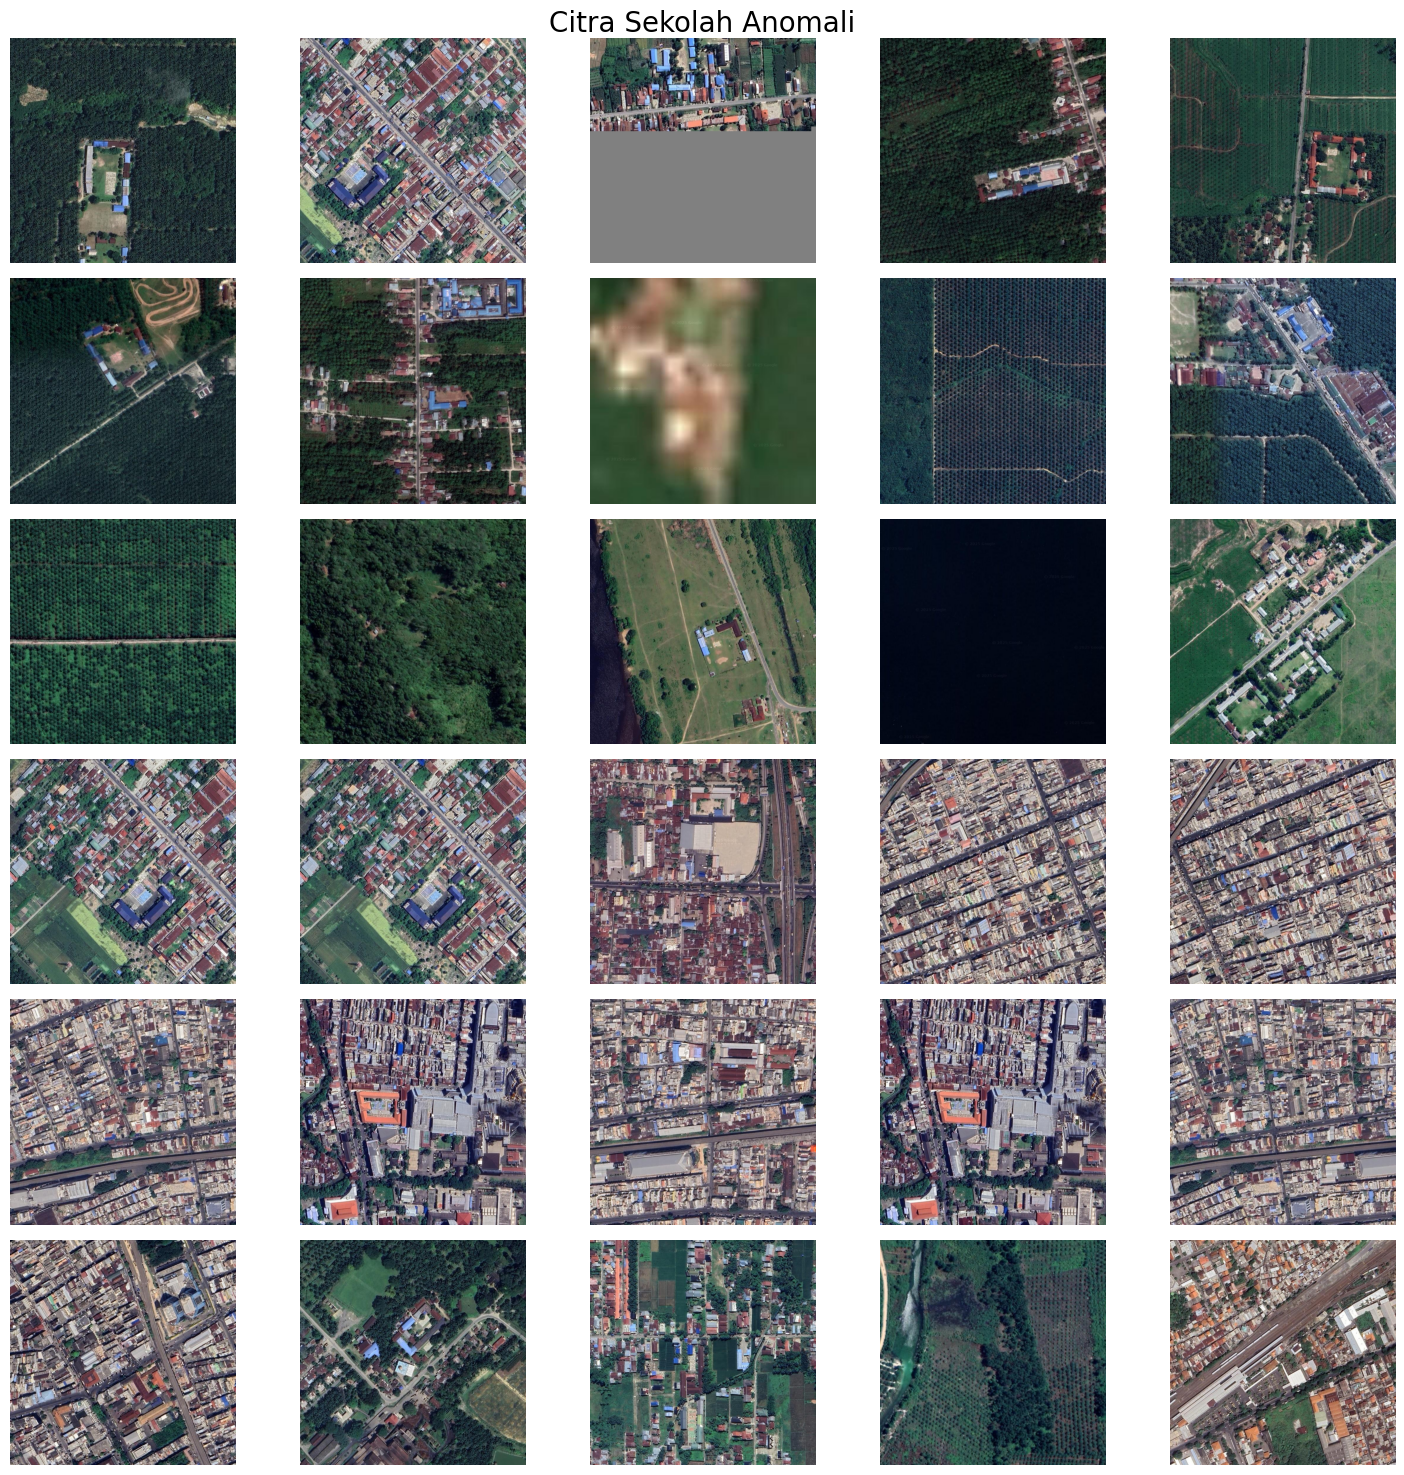

✅ Grid citra anomali disimpan ke: ../hasil/anomaly_detection\HOG_anomali_image_grid_2.png


In [74]:
# plot citra sekolah yang anomali
plot_anomaly_images(df_ori, anomali_list[30:60], filename="HOG_anomali_image_grid_2.png")

## LBP

In [6]:
anomali_list = plot_pca_3d(
    features_list=features_list,
    feature_names=feature_names,
    y=y,
    index=index,
    feature_idx=1,
    marker_size=3,
    z_score_thresh=2
)

print("Sekolah anomali:", anomali_list)
print("Banyak anomali:", len(anomali_list))


✅ Visualisasi disimpan ke: ../hasil/anomaly_detection\LBP_pca_anomaly.html
✅ Daftar anomali disimpan ke: ../hasil/anomaly_detection\LBP_anomali_list.csv
Jumlah anomali terdeteksi: 136
Sekolah anomali: [25, 263, 452, 507, 513, 521, 566, 1065, 1161, 1168, 1216, 1242, 1570, 1588, 1651, 1660, 1671, 1762, 1774, 1787, 1810, 1817, 1847, 1857, 1860, 1881, 1910, 1940, 1942, 1943, 2016, 2021, 2023, 2054, 2071, 2176, 2184, 2346, 2421, 2476, 2980, 3077, 3134, 3186, 3234, 3435, 3685, 4922, 6148, 7094, 7405, 7440, 7448, 7510, 7606, 7639, 7684, 7694, 7718, 7719, 7723, 7742, 7744, 7787, 7789, 7825, 7926, 8004, 8038, 8047, 8054, 8161, 8173, 8471, 8518, 8573, 8645, 8746, 8799, 8965, 9142, 9187, 9215, 9250, 10050, 10075, 10089, 10205, 10217, 10227, 10539, 10756, 11169, 11277, 11314, 11366, 11387, 11391, 11444, 11494, 11502, 11585, 11702, 11737, 11739, 11764, 11846, 11894, 11910, 11993, 11998, 12006, 12023, 12138, 12263, 12296, 12585, 12594, 12611, 12643, 12721, 12871, 13032, 13060, 13085, 13147, 13209, 1

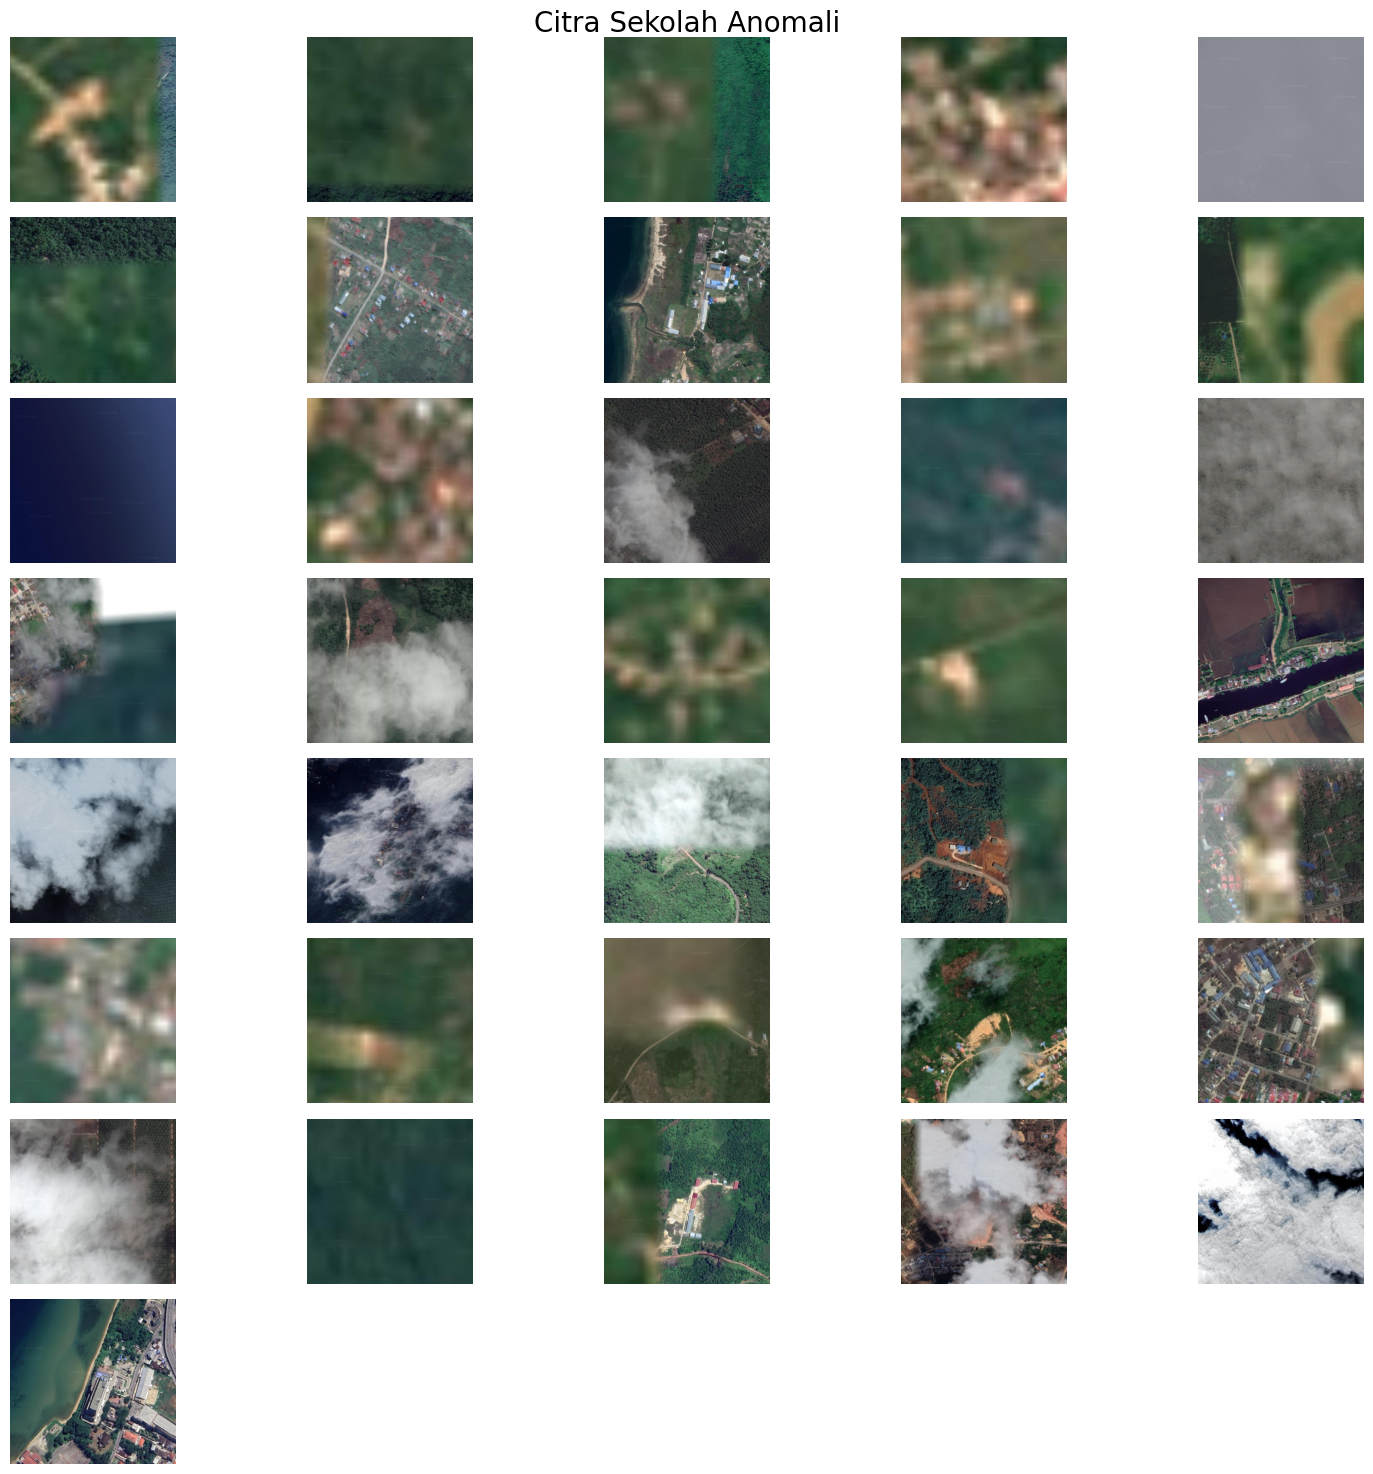

✅ Grid citra anomali disimpan ke: ../hasil/anomaly_detection\LBP_anomali_images_grid_3.png


In [81]:
# plot citra sekolah yang anomali
plot_anomaly_images(df_ori, anomali_list[100:], filename="LBP_anomali_images_grid_3.png")

---
## **🔍 Analisis & 📝 Kesimpulan**
---

---

🔍 **Analisis Hasil Deteksi Anomali**

Berdasarkan hasil visualisasi dan deteksi anomali menggunakan fitur **HOG** dan **LBP**, dapat disimpulkan beberapa hal penting:

1. **Fitur HOG (Histogram of Oriented Gradients)**  
   - HOG **mampu mendeteksi anomali** berdasarkan pola tekstur dan gradien arah citra.  
   - Namun, hasil deteksinya **kurang selektif**, karena masih banyak **citra satelit yang sebenarnya normal** tetapi ikut terdeteksi sebagai anomali (*false positive*).  
   - Hal ini dapat terjadi karena HOG sensitif terhadap **perubahan pencahayaan** dan **perbedaan orientasi kecil**, sehingga citra yang sedikit berbeda dari mayoritas bisa dianggap “aneh”.

2. **Fitur LBP (Local Binary Pattern)**  
   - LBP menunjukkan **kinerja yang jauh lebih baik** dalam mendeteksi anomali visual.  
   - Dari hasil sampling citra, seluruh anomali yang terdeteksi benar-benar menggambarkan kondisi citra yang **tidak normal**, seperti:  
     - Citra yang **terpotong sebagian**  
     - Citra **buram atau tidak fokus (blur)**  
     - Citra **tertutup awan tebal**  
     - Citra yang menampilkan **laut atau area kosong** alih-alih bangunan sekolah  
   - Hal ini menunjukkan bahwa **LBP lebih robust terhadap variasi cahaya dan struktur tekstur** dibandingkan HOG.

---

📝 **Kesimpulan** 
- **LBP** lebih direkomendasikan sebagai metode utama deteksi anomali pada citra satelit sekolah karena menghasilkan deteksi yang **lebih akurat dan relevan secara visual**.  
- Hasil ini dapat digunakan untuk **membersihkan dataset**, dengan menghapus citra anomali sebelum proses *feature extraction* lanjutan atau *clustering*.  

---


---
# **PENYIMPANAN HASIL**
---

## File CSV

In [82]:
# ============================
# Simpan Hasil Deteksi Anomali
# ============================
df_anomali = df_ori.copy()

# Tambahkan kolom baru 'anomaly' ke dataframe anomali
df_anomali["anomali"] = df_anomali["nomor"].isin(anomali_list).astype(int)
# 1 = anomali, 0 = normal

# Simpan ke file CSV
output_path = "../data/data_deteksi_anomali.csv"
df_anomali.to_csv(output_path, index=False)

print(f"Hasil deteksi anomali berhasil disimpan ke: {output_path}")
print("Jumlah data anomali:", df_anomali["anomali"].sum())
print("Jumlah data normal :", len(df_anomali) - df_anomali["anomali"].sum())

df_anomali.head()

Hasil deteksi anomali berhasil disimpan ke: ../data/data_deteksi_anomali.csv
Jumlah data anomali: 136
Jumlah data normal : 13940


nomor kode_sekolah                  nama_sekolah  \
0      1     10100139  SMA NEGERI 1 LEMBAH SEULAWAH   
1      2     10100170       SMA NEGERI MODAL BANGSA   
2      3     10100176            SMAS MALEM PUTRA 1   
3      4     10100177          SMA NEGERI 1 LEUPUNG   
4      5     10100179        SMA NEGERI 1 PULO ACEH   

                                              alamat  kabupaten_kota provinsi  \
0  JL. BANDA ACEH-MEDAN KM.57,5 Lamtamot Kec. Lem...  Kab Aceh Besar     Aceh   
1  JL. BANDARA SIM KM. 12,5 Cot Geundreut Kec. Bl...  Kab Aceh Besar     Aceh   
2  JL.SYEH ABDULLAH KAN-AN Leugeu Kec. Darul Imar...  Kab Aceh Besar     Aceh   
3  JL. BANDA ACEH CALANG KM-18 DAYAH MAMPLAM Kec....  Kab Aceh Besar     Aceh   
4  JL. RAJA KANDANG Alue Riyeung Kec. Pulo Aceh K...  Kab Aceh Besar     Aceh   

  akreditasi       long       lat  \
0          A  95.682881  5.370129   
1          A  95.395695  5.508437   
2          C  95.330857  5.493038   
3          B  95.241723  5.435694   
4          B  95.144949  5.615454   

                                      dir_gambar_ori  \
0  ../data/gambar/gambar_ori/ACEH/KAB ACEH BESAR/...   
1  ../data/gambar/gambar_ori/ACEH/KAB ACEH BESAR/...   
2  ../data/gambar/gambar_ori/ACEH/KAB ACEH BESAR/...   
3  ../data/gambar/gambar_ori/ACEH/KAB ACEH BESAR/...   
4  ../data/gambar/gambar_ori/ACEH/KAB ACEH BESAR/...   

                                    dir_gambar_titik  \
0  ../data/gambar/gambar_titik/ACEH/KAB ACEH BESA...   
1  ../data/gambar/gambar_titik/ACEH/KAB ACEH BESA...   
2  ../data/gambar/gambar_titik/ACEH/KAB ACEH BESA...   
3  ../data/gambar/gambar_titik/ACEH/KAB ACEH BESA...   
4  ../data/gambar/gambar_titik/ACEH/KAB ACEH BESA...   

                           dir_gambar_kotak_dan_yolo keterangan  anomali  
0  ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses        0  
1  ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses        0  
2  ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses        0  
3  ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses        0  
4  ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses        0

In [83]:
kondisi = df_anomali['anomali'] == 1
df_anomali[kondisi].head()

nomor kode_sekolah               nama_sekolah  \
24      25     10100545              SMAN 1 DELIMA   
261    263     10107498           SMAN 2 SEULIMEUM   
449    452     10201989  SMA NEGERI 1 SIMPANGEMPAT   
504    507     10203524           SMAN 1 PARBULUAN   
510    513     10203551              SMAN 1 SUMBUL   

                                                alamat  kabupaten_kota  \
24   JL. B. ACEH - MEDAN 112 Sukon Kec. Grong-Grong...       Kab Pidie   
261  DESA ATEUK LAMTEUBA ATEUK Kec. Seulimeum Kab. ...  Kab Aceh Besar   
449  JL. TIGANDERKET, SIMPANG EMPAT di Begand... Be...        Kab Karo   
504  JL. SM RAJA KM 20 SIGALINGGING Parbuluan Iv Ke...       Kab Dairi   
510  JL. SISINGAMANGARAJA ATAS NO. 136 SUMBU... Peg...       Kab Dairi   

           provinsi akreditasi        long       lat  \
24             Aceh          B   98.624815  3.591694   
261            Aceh          B   95.603319  5.511184   
449  Sumatera Utara          B  115.986923 -3.406666   
504  Sumatera Utara          A   98.441192  2.664763   
510  Sumatera Utara          A   98.413682  2.742638   

                                        dir_gambar_ori  \
24   ../data/gambar/gambar_ori/ACEH/KAB PIDIE/sman_...   
261  ../data/gambar/gambar_ori/ACEH/KAB ACEH BESAR/...   
449  ../data/gambar/gambar_ori/SUMATERA UTARA/KAB K...   
504  ../data/gambar/gambar_ori/SUMATERA UTARA/KAB D...   
510  ../data/gambar/gambar_ori/SUMATERA UTARA/KAB D...   

                                      dir_gambar_titik  \
24   ../data/gambar/gambar_titik/ACEH/KAB PIDIE/sma...   
261  ../data/gambar/gambar_titik/ACEH/KAB ACEH BESA...   
449  ../data/gambar/gambar_titik/SUMATERA UTARA/KAB...   
504  ../data/gambar/gambar_titik/SUMATERA UTARA/KAB...   
510  ../data/gambar/gambar_titik/SUMATERA UTARA/KAB...   

                             dir_gambar_kotak_dan_yolo keterangan  anomali  
24   ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses        1  
261  ../data/gambar/gambar_kotak_dan_yolo/ACEH/KAB ...     sukses        1  
449  ../data/gambar/gambar_kotak_dan_yolo/SUMATERA ...     sukses        1  
504  ../data/gambar/gambar_kotak_dan_yolo/SUMATERA ...     sukses        1  
510  ../data/gambar/gambar_kotak_dan_yolo/SUMATERA ...     sukses        1

---

🔍 Kesimpulan Deteksi Anomali

Proses **deteksi anomali** telah berhasil dilakukan menggunakan fitur-fitur citra satelit.  
Dari hasil analisis, metode **HOG** mampu mendeteksi beberapa anomali, namun masih terdapat beberapa citra normal yang terdeteksi sebagai anomali.  
Sementara itu, metode **LBP** menunjukkan performa yang lebih baik karena hampir seluruh citra yang terdeteksi merupakan citra **benar-benar anomali** (seperti citra terpotong, blur, tertutup awan, atau menampilkan laut).


## File Fitur

Pada tahap ini, dilakukan beberapa langkah penting sebelum melanjutkan ke proses *clustering*:

1. **Memuat data fitur ResNet50** (`.npy`) dan metadata hasil deteksi anomali (`.csv`).  
2. **Memastikan konsistensi** antara jumlah data fitur dan metadata.  
3. **Membuang data anomali** berdasarkan hasil deteksi sebelumnya (`anomali == 1`).  
4. **Menyimpan ulang** fitur hasil filter (`resnet50_features_filtered.npy`) hanya untuk data yang normal.  
5. **Melakukan validasi tambahan**, seperti pemeriksaan urutan data, jumlah data yang dibuang, dan dimensi fitur.

In [17]:
# ============================
# Path Configuration
# ============================
FEATURE_PATH = "../hasil/features/features/resnet50_features.npy"
OUTPUT_FILTERED_PATH = "../hasil/features/features/resnet50_features_filtered.npy"
CSV_PATH = "../data/data_deteksi_anomali.csv"

# ============================
# Load Data
# ============================
features_resnet = np.load(FEATURE_PATH)
df_anomali = pd.read_csv(CSV_PATH)

# ============================
# Validasi Awal
# ============================
assert len(features_resnet) == len(df_anomali), "Panjang data fitur dan metadata tidak cocok!"

# ============================
# Filter Hanya Data Normal
# ============================
mask_normal = df_anomali["anomali"] == 0
features_filtered = features_resnet[mask_normal.values]

# Simpan hasil fitur yang sudah difilter
os.makedirs(os.path.dirname(OUTPUT_FILTERED_PATH), exist_ok=True)
np.save(OUTPUT_FILTERED_PATH, features_filtered)

print("====================================")
print("Fitur ResNet50 Berhasil Difilter")
print("====================================")
print(f"Lokasi penyimpanan : {OUTPUT_FILTERED_PATH}")
print(f"Jumlah data awal   : {len(features_resnet)}")
print(f"Jumlah data normal : {features_filtered.shape[0]}")
print(f"Jumlah data anomali: {df_anomali['anomali'].sum()}")

# ============================
# Pemeriksaan Konsistensi
# ============================
print("\n============================")
print("Pemeriksaan Konsistensi Data")
print("============================")

print("Jumlah data di CSV              :", len(df_anomali))
print("Jumlah data di fitur asli       :", features_resnet.shape[0])
print("Jumlah data di fitur (filtered) :", features_filtered.shape[0])

# 1. Cek urutan kolom 'nomor'
if df_anomali["nomor"].is_monotonic_increasing:
    print("✅ Kolom 'nomor' berurutan dengan benar.")
else:
    print("⚠️ Kolom 'nomor' tidak berurutan. Pastikan urutan sama saat ekstraksi fitur.")

# 2. Hitung jumlah data yang dibuang
selisih = features_resnet.shape[0] - features_filtered.shape[0]
print(f"Jumlah data yang dibuang (anomali): {selisih}")

# 3. Validasi dimensi fitur
if features_resnet.shape[1] == features_filtered.shape[1]:
    print("✅ Dimensi fitur sama antara fitur asli dan hasil filter.")
else:
    print("⚠️ Dimensi fitur berbeda! Cek kembali proses filtering.")

# 4. Contoh baris acak untuk
idx = random.randint(0, len(df_anomali) - 1)
print(f"\nContoh baris ke-{idx}:")
print("Nomor sekolah :", df_anomali.loc[idx, 'nomor'])
print("Label anomali :", df_anomali.loc[idx, 'anomali'])
print("Shape fitur   :", features_resnet[idx].shape)

Fitur ResNet50 Berhasil Difilter
Lokasi penyimpanan : ../hasil/features/features/resnet50_features_filtered.npy
Jumlah data awal   : 14076
Jumlah data normal : 13940
Jumlah data anomali: 136

Pemeriksaan Konsistensi Data
Jumlah data di CSV              : 14076
Jumlah data di fitur asli       : 14076
Jumlah data di fitur (filtered) : 13940
✅ Kolom 'nomor' berurutan dengan benar.
Jumlah data yang dibuang (anomali): 136
✅ Dimensi fitur sama antara fitur asli dan hasil filter.

Contoh baris ke-8246:
Nomor sekolah : 8387
Label anomali : 0
Shape fitur   : (100352,)


---

🚀 Tahap Selanjutnya: Clustering Citra Satelit

Deteksi anomali telah selesai dan proyek dapat dilanjutkan ke tahap utama berikutnya, yaitu **clustering citra satelit**.  
Tahapan ini akan dilakukan pada notebook berikut:

📘 [**`5_clustering_citra_satelit.ipynb`**](./5_clustering_citra_satelit.ipynb)